# Hybrid-Kringing independent variable analysis (ML preprocessing)

**Justification:** Wong et al., 2021 (10.1016/j.jclepro.2021.128411) found that using Hybrid-Kringing to trim the number of independent variables helps boost NO2 predicting XGBoost model R^2 score.

Here we explore this idea, and see if we find simular results.

In [1]:
# import dependencies
import pykrige
import pandas as pd 
import scipy
from scipy import stats

In [2]:
# bring in data
# import data, remove non-necessary columns
DATA_LOCATION = r'C:\Users\xavie\Documents\DATASETS\master_no2_daily_nov30.csv'
in_data = pd.read_csv(DATA_LOCATION)
print(in_data.columns)
in_data.head()

Index(['Unnamed: 0', 'lat', 'long', 'State_Name', 'Date_Local', 'mean_no2',
       'year', 'month', 'dayofmonth', 'dayofyear', 'counter', 'weekend',
       'station_id', 'sp', 'swvl1', 't2m', 'tp', 'u10', 'v10', 'blh', 'u100',
       'v100', 'p_roads_1000', 's_roads_1700', 's_roads_3000', 'tropomi',
       'pod_den_1100', 'Z_r', 'Z'],
      dtype='object')


,Unnamed: 0,lat,long,State_Name,Date_Local,mean_no2,year,month,dayofmonth,dayofyear,...,blh,u100,v100,p_roads_1000,s_roads_1700,s_roads_3000,tropomi,pod_den_1100,Z_r,Z
0,0,33.553056,-86.815,Alabama,1/1/2019,4.314286,2019,1,1,1,...,464.630521,-0.414841,1.947801,0.0,3.82894,8.555133,4.437010e+15,2642.464651,0.0,178
1,1,33.553056,-86.815,Alabama,1/9/2019,4.957143,2019,1,9,9,...,464.630521,-0.414841,1.947801,0.0,3.82894,8.555133,4.437010e+15,2642.464651,0.0,178
2,2,33.553056,-86.815,Alabama,1/10/2019,5.891667,2019,1,10,10,...,464.630521,-0.414841,1.947801,0.0,3.82894,8.555133,4.437010e+15,2642.464651,0.0,178
3,3,33.553056,-86.815,Alabama,1/11/2019,14.500000,2019,1,11,11,...,464.630521,-0.414841,1.947801,0.0,3.82894,8.555133,4.437010e+15,2642.464651,0.0,178
4,4,33.553056,-86.815,Alabama,1/12/2019,7.254167,2019,1,12,12,...,464.630521,-0.414841,1.947801,0.0,3.82894,8.555133,4.437010e+15,2642.464651,0.0,178


In [28]:
# convert to monthly averaged and make a January dataframe
monthly = in_data.groupby(['station_id', 'month']).mean().reset_index()

january = monthly.loc[monthly['month'] == 1]
lat_lon = january[['lat', 'long']].to_numpy()

january.sort_values(['station_id', 'month'], axis=0, inplace=True)
january.reset_index(inplace=True)
print(january.columns)
january.drop(['index', 'Unnamed: 0', 'counter', 'dayofyear', 'weekend', 'dayofmonth'], axis=1, inplace=True)


january.head()

Index(['index', 'station_id', 'month', 'Unnamed: 0', 'lat', 'long', 'mean_no2',
       'year', 'dayofmonth', 'dayofyear', 'counter', 'weekend', 'sp', 'swvl1',
       't2m', 'tp', 'u10', 'v10', 'blh', 'u100', 'v100', 'p_roads_1000',
       's_roads_1700', 's_roads_3000', 'tropomi', 'pod_den_1100', 'Z_r', 'Z'],
      dtype='object')


,station_id,month,lat,long,mean_no2,year,sp,swvl1,t2m,tp,...,blh,u100,v100,p_roads_1000,s_roads_1700,s_roads_3000,tropomi,pod_den_1100,Z_r,Z
0,1,1,33.553056,-86.815,11.176059,2019.0,99724.87984,0.426193,280.264083,0.006967,...,464.630521,-0.414841,1.947801,0.0,3.82894,8.555133,4.437010e+15,2642.464651,0.0,178.0
1,1,2,33.553056,-86.815,10.170781,2019.0,99859.52138,0.426193,280.264083,0.003241,...,608.579581,0.351088,-0.346133,0.0,3.82894,8.555133,3.565690e+15,2642.464651,0.0,178.0
2,1,3,33.553056,-86.815,9.005671,2019.0,99332.41407,0.426193,280.264083,0.004815,...,587.417161,0.726758,1.944154,0.0,3.82894,8.555133,3.475220e+15,2642.464651,0.0,178.0
3,1,4,33.553056,-86.815,9.835197,2019.0,99325.53875,0.426193,280.264083,0.002818,...,640.471893,0.906035,2.034346,0.0,3.82894,8.555133,3.646560e+15,2642.464651,0.0,178.0
4,1,5,33.553056,-86.815,9.251750,2019.0,99273.97391,0.426193,280.264083,0.003752,...,617.004901,0.723391,1.006420,0.0,3.82894,8.555133,2.270010e+15,2642.464651,0.0,178.0


In [29]:
january.to_csv(r'C:\Users\xavie\Documents\DATASETS\master_monthly_no2_jan4.csv')

In [343]:
keep_cols = ['mean_no2', 'sp', 'swvl1', 't2m', 'tp', 'u10', 'v10', 'blh', 'u100', 'v100', 'p_roads_1000', 's_roads_1700', 's_roads_3000', 'tropomi', 'pod_den_1100', 'Z_r', 'Z']
in_data = january
in_data = in_data[keep_cols]


# standardize column headers
for col in list(in_data.columns):
        if in_data[col].dtypes == object:
            in_data[col].replace(' ', '_', regex=True, inplace=True)
        if ' ' in str(col)[:-1]:
            new = str(col).replace(' ', '_')
            if new[-1] == '_':
                new = new[:-1]
            in_data.rename(columns={str(col): new}, inplace=True)
        
            
in_data.head()

,mean_no2,sp,swvl1,t2m,tp,u10,v10,blh,u100,v100,p_roads_1000,s_roads_1700,s_roads_3000,tropomi,pod_den_1100,Z_r,Z
0,11.176059,99724.87984,0.426193,280.264083,0.006967,0.489328,-0.052422,464.630521,-0.414841,1.947801,0.00000,3.828940,8.555133,4.437010e+15,2642.464651,0.000000,178.0
12,12.312605,99646.95963,0.450334,280.307223,0.006384,0.500518,-0.064837,464.630521,-0.414841,1.947801,5.95545,2.959208,11.084034,4.844770e+15,2630.140482,0.860871,189.0
24,21.821502,97269.24728,0.144823,284.142995,0.002700,-0.595943,-0.771905,421.091444,0.406358,0.662893,0.00000,10.210007,27.894930,1.030000e+16,6362.811560,0.000000,334.0
36,23.353431,97010.27716,0.151290,284.001643,0.002956,-0.656265,-0.836423,421.091444,0.406358,0.662893,14.72194,6.752895,34.580018,8.786030e+15,7065.979555,0.000000,333.0
48,10.139339,98177.93446,0.128340,285.059027,0.001775,-0.611155,-0.783943,494.862550,0.879382,0.716942,0.00000,5.304251,10.782592,3.269870e+15,55.396922,0.000000,262.0


Chen et al., 2020 as well as Wong et al., 2021 both used Spearman correlation and expected effect directions to trim variables (p < 0.3 removed)

In [344]:
# calculate Spearman coefficient between each independent variable and NO2
mean_no2 = in_data[['mean_no2']].to_numpy()


for var in list(in_data.columns):
    var_numpy = in_data[[var]].to_numpy()
    corr, p =  scipy.stats.spearmanr(mean_no2, var_numpy, nan_policy='omit', alternative='two-sided')
    print('Variable: %s' % var)
    print('Correlation w/ NO2 = %s, p score = %s' % (corr, p))
    
    if abs(corr) < 0.2:
        print('Consider removing')
    print('\n')

Variable: mean_no2
Correlation w/ NO2 = 0.9999999999999999, p score = 0.0


Variable: sp
Correlation w/ NO2 = 0.18882685883143055, p score = 7.701760156339729e-05
Consider removing


Variable: swvl1
Correlation w/ NO2 = 0.023465156265842047, p score = 0.6263051968495408
Consider removing


Variable: t2m
Correlation w/ NO2 = 0.21439141048484903, p score = 6.771759284181397e-06


Variable: tp
Correlation w/ NO2 = 0.1490184461855597, p score = 0.0018753914953458454
Consider removing


Variable: u10
Correlation w/ NO2 = -0.13721640392750606, p score = 0.004228708747749465
Consider removing


Variable: v10
Correlation w/ NO2 = -0.10839480684678732, p score = 0.024090702469024627
Consider removing


Variable: blh
Correlation w/ NO2 = 0.1260015075094438, p score = 0.008669702545827645
Consider removing


Variable: u100
Correlation w/ NO2 = 0.008353481033043434, p score = 0.8623957906098056
Consider removing


Variable: v100
Correlation w/ NO2 = -0.005270619711651638, p score = 0.9129183724880

In [384]:
# drop variables when necessary
drop_cols = ['u10', 'v10', 'swvl1', 'u100', 'v100']
new_data = in_data.drop(drop_cols, axis=1)


Now we make a traditional LUR model and use it to extract Variance Inflation Factors (VIF) and potentially remove variables with high (> 3) VIF relative to their correlation values.

Read more: https://www.investopedia.com/terms/v/variance-inflation-factor.asp 

In [390]:
from sklearn.linear_model import LinearRegression

# split data into dependent and independent data frames
Y = new_data[['mean_no2']].to_numpy()
not_no2 = [i for i in list(new_data.columns) if i not in ['mean_no2']]
print(not_no2)
X = new_data[not_no2]
X = X.reset_index()
X = X.drop('index', axis=1)

# create a linear regression model (we could expirmenet with Lasso or Ridge regression)
l_model = LinearRegression().fit(X, Y)
print('Linear regression score: %s' % l_model.score(X, Y))

for i, var in enumerate(list(X.columns)):
    print('Variable: %s' % var) 
    coef = l_model.coef_[0][i]
    print('Regression coef = %s\n' % coef)
    

X.head()

['sp', 't2m', 'tp', 'blh', 'p_roads_1000', 's_roads_1700', 's_roads_3000', 'tropomi', 'pod_den_1100', 'Z_r', 'Z']
Linear regression score: 0.7006346774624043
Variable: sp
Regression coef = -0.0008234897608308758

Variable: t2m
Regression coef = 0.0032190593105780258

Variable: tp
Regression coef = 6.297349318769218e-07

Variable: blh
Regression coef = -0.00021664527285197806

Variable: p_roads_1000
Regression coef = 0.6261201201463322

Variable: s_roads_1700
Regression coef = -0.002127076008242656

Variable: s_roads_3000
Regression coef = 0.06902221585530703

Variable: tropomi
Regression coef = 9.905390251692652e-16

Variable: pod_den_1100
Regression coef = 0.00012577603551721265

Variable: Z_r
Regression coef = -0.004493029112496458

Variable: Z
Regression coef = -0.008505108468922142



,sp,t2m,tp,blh,p_roads_1000,s_roads_1700,s_roads_3000,tropomi,pod_den_1100,Z_r,Z
0,99724.87984,280.264083,0.006967,464.630521,0.00000,3.828940,8.555133,4.437010e+15,2642.464651,0.000000,178.0
1,99646.95963,280.307223,0.006384,464.630521,5.95545,2.959208,11.084034,4.844770e+15,2630.140482,0.860871,189.0
2,97269.24728,284.142995,0.002700,421.091444,0.00000,10.210007,27.894930,1.030000e+16,6362.811560,0.000000,334.0
3,97010.27716,284.001643,0.002956,421.091444,14.72194,6.752895,34.580018,8.786030e+15,7065.979555,0.000000,333.0
4,98177.93446,285.059027,0.001775,494.862550,0.00000,5.304251,10.782592,3.269870e+15,55.396922,0.000000,262.0


Text(1, 35, 'R2 = 0.7')

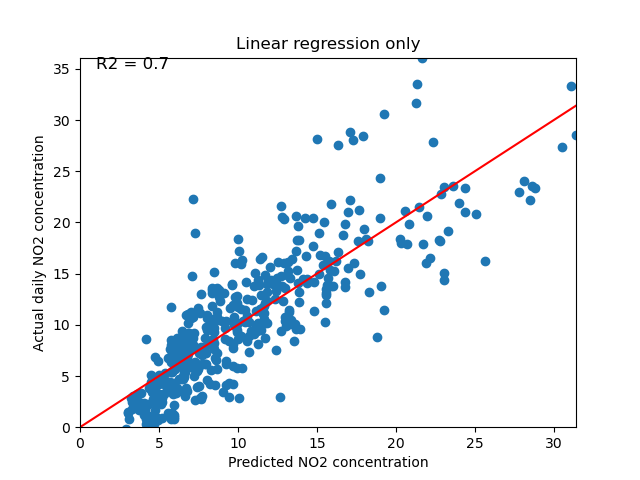

In [391]:
# make prediction plot with the linear model
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib widget
prediction = l_model.predict(X)

plt.title('Linear regression only')
plt.scatter(prediction, Y)
plt.plot(np.arange(0, 60, 0.1), np.arange(0, 60, 0.1), c='red')
plt.xlim(0, np.amax(prediction))
plt.ylim(0, np.amax(Y))
plt.xlabel('Predicted NO2 concentration')
plt.ylabel('Actual daily NO2 concentration')
plt.text(1, 35, 'R2 = %s' % round(r2_score(Y, prediction), 2), fontsize='large')

In [392]:
# explore VIF scores by making a dataframe
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['variable'] = X.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data['consider_dropping'] = 'Yes'
vif_data.loc[vif_data['VIF'] < 3, 'consider_dropping'] = 'No'
  
vif_data.head(n=X.shape[0])

,variable,VIF,consider_dropping
0,sp,7.855112,Yes
1,t2m,1.200827,No
2,tp,1.321986,No
3,blh,1.322960,No
4,p_roads_1000,1.193123,No
5,s_roads_1700,5.769611,Yes
6,s_roads_3000,1.841103,No
7,tropomi,3.698138,Yes
8,pod_den_1100,1.803657,No
9,Z_r,1.102600,No


Next we use Regression Kringing to improve our initial LUR model. The regression kringing prediction can be used as an XGBoost input.

See example: https://geostat-framework.readthedocs.io/projects/pykrige/en/latest/examples/07_regression_kriging2d.html#sphx-glr-examples-07-regression-kriging2d-py 

The pykrige documentation is weak. This is pulled from the source code .fit(p, x, y) docstring:

    Fit the regression method and also Krige the residual.
        Parameters
        ----------
        p: ndarray
            (Ns, d) array of predictor variables (Ns samples, d dimensions)
            for regression
        x: ndarray
            ndarray of (x, y) points. Needs to be a (Ns, 2) array
            corresponding to the lon/lat, for example 2d regression kriging.
            array of Points, (x, y, z) pairs of shape (N, 3) for 3d kriging
        y: ndarray
            array of targets 

In [393]:
out_X = X.loc[lambda X: X.index!= 1]
print(out_X.shape)
X.head(n=100)

(432, 11)


,sp,t2m,tp,blh,p_roads_1000,s_roads_1700,s_roads_3000,tropomi,pod_den_1100,Z_r,Z
0,99724.87984,280.264083,0.006967,464.630521,0.00000,3.828940,8.555133,4.437010e+15,2642.464651,0.000000,178.0
1,99646.95963,280.307223,0.006384,464.630521,5.95545,2.959208,11.084034,4.844770e+15,2630.140482,0.860871,189.0
2,97269.24728,284.142995,0.002700,421.091444,0.00000,10.210007,27.894930,1.030000e+16,6362.811560,0.000000,334.0
3,97010.27716,284.001643,0.002956,421.091444,14.72194,6.752895,34.580018,8.786030e+15,7065.979555,0.000000,333.0
4,98177.93446,285.059027,0.001775,494.862550,0.00000,5.304251,10.782592,3.269870e+15,55.396922,0.000000,262.0
...,...,...,...,...,...,...,...,...,...,...,...
95,99269.96331,285.127867,0.005105,664.830978,0.00000,4.161562,7.197573,1.896360e+15,8.066816,1.421720,276.0
96,94701.89088,283.370150,0.006687,514.463807,0.00000,0.000000,0.000000,2.183910e+15,120.683022,0.000000,513.0
97,98349.81728,285.023230,0.005701,593.736151,0.00000,3.547216,4.945486,1.865570e+15,8.859233,1.885530,275.0
98,97643.95183,284.212753,0.005730,453.603265,0.00000,2.302154,8.485324,2.862630e+15,312.233189,0.000000,153.0


In [397]:
# build on LUR model with Regression Kringing with the "leave one out method"
from pykrige.rk import RegressionKriging

m_rk = RegressionKriging(regression_model=l_model, n_closest_points=20)

actuals = []
predicts = []
# implement leave one out method
for i in list(range(0, X.shape[0])):
    print('Index = %s' % i)
    out_X = np.expand_dims(X.iloc[i], axis=1).T
    out_Y = Y[i]
    out_latlon = np.expand_dims(lat_lon[i], axis=1).T
    
    
    # OKAY FIX THIS ANNOYING ISSUE WHERE IT DROPS FOR INDEX 0 but for whatever reason can't for any other index
    in_X = X.iloc[lambda X: X.index != i]
    in_Y = np.delete(Y, i, axis=0)
    in_latlon = np.delete(lat_lon, i, axis=0)
    
    m_rk.fit(in_X, in_latlon, in_Y)
    print("Regression Score: ", m_rk.regression_model.score(X, Y))
    
    kring_prediction = m_rk.predict(out_X, out_latlon)
    print('Prediction: %s' % kring_prediction)
    print('Actual: %s' % out_Y)
    actuals.append(out_Y[0])
    predicts.append(kring_prediction[0][0])
    print('\n')

Index = 0
Finished learning regression model
Finished kriging residuals


C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.700632233934052
Prediction: [[7.75487194]]
Actual: [11.17605874]


Index = 1
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700638203377429
Prediction: [[12.15426585]]
Actual: [12.3126051]


Index = 2
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006087119169938
Prediction: [[18.98357779]]
Actual: [21.82150206]


Index = 3
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006326378868837
Prediction: [[27.68493793]]
Actual: [23.353431]


Index = 4
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006303768115205
Prediction: [[9.87003604]]
Actual: [10.13933877]


Index = 5
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005990521724592
Prediction: [[19.93637586]]
Actual: [22.18131655]


Index = 6
Finished learning regression model
Finished kriging residuals
Regression Score:  0.70051072533746

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.700632972601208
Prediction: [[6.89245877]]
Actual: [8.6902291]


Index = 12
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006255445831986
Prediction: [[7.56968077]]
Actual: [11.88387094]


Index = 13
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006215818384383
Prediction: [[15.30043436]]
Actual: [12.94781968]


Index = 14
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006250623620726
Prediction: [[19.95733414]]
Actual: [17.99845716]


Index = 15
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006316030962594
Prediction: [[21.55364627]]
Actual: [20.62050877]


Index = 16
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006250405925207
Prediction: [[14.41594256]]
Actual: [18.99947847]


Index = 17
Finished learning regressio

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006333412189236
Prediction: [[7.35372157]]
Actual: [9.47699858]


Index = 23
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006127338261963
Prediction: [[9.68941943]]
Actual: [15.17982581]


Index = 24
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006062960747801
Prediction: [[11.48824517]]
Actual: [15.9694249]


Index = 25
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006262486548969
Prediction: [[8.23342969]]
Actual: [11.094389]


Index = 26
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700594397861837
Prediction: [[15.96663486]]
Actual: [20.40015939]


Index = 27
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006327824846775
Prediction: [[6.9314089]]
Actual: [8.07757719]


Index = 28
Finished learning regression mode

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[10.57793379]]
Actual: [7.57872645]


Index = 32
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006291565230827
Prediction: [[11.07543282]]
Actual: [16.11022561]


Index = 33
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006304677755901
Prediction: [[10.94888742]]
Actual: [15.2480967]


Index = 34
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006283769829964
Prediction: [[14.56517654]]
Actual: [18.81129035]


Index = 35
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700633732137345
Prediction: [[7.78464366]]
Actual: [10.41458629]


Index = 36
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006305254513672
Prediction: [[9.77861987]]
Actual: [11.26834752]


Index = 37
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006015915797674
Prediction: [[17.38138531]]

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.700466309599878
Prediction: [[26.6532875]]
Actual: [22.17810976]


Index = 43
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005928410416615
Prediction: [[26.08896702]]
Actual: [24.06037771]


Index = 44
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006352993924074
Prediction: [[21.42576365]]
Actual: [22.74283365]


Index = 45
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005773447947329
Prediction: [[21.41623428]]
Actual: [19.20895428]


Index = 46
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005124331321579
Prediction: [[26.83229018]]
Actual: [23.35912774]


Index = 47
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006167163620316
Prediction: [[28.48232277]]
Actual: [33.35293247]


Index = 48
Finished learning regres

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006323922122146
Prediction: [[7.34174249]]
Actual: [8.41298874]


Index = 52
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006302395942354
Prediction: [[12.83244175]]
Actual: [11.28306691]


Index = 53
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006345041483766
Prediction: [[9.45081108]]
Actual: [7.85643984]


Index = 54
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006262996520094
Prediction: [[8.12784141]]
Actual: [5.55867232]


Index = 55
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700634478978182
Prediction: [[7.56702607]]
Actual: [7.2650939]


Index = 56
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006139910693016
Prediction: [[22.25382194]]
Actual: [20.98653471]


Index = 57
Finished learning regression model
Finished kriging residuals
Regression Score:  0.70063487836

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[9.8991183]]
Actual: [2.93449394]


Index = 63
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006192027605076
Prediction: [[10.1479553]]
Actual: [12.83135329]


Index = 64
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700635068975788
Prediction: [[16.27689009]]
Actual: [18.19048142]


Index = 65
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006342341349863
Prediction: [[14.04326575]]
Actual: [16.69518477]


Index = 66
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006254939132799
Prediction: [[12.03270854]]
Actual: [9.41288747]


Index = 67
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006350784399552
Prediction: [[8.66732423]]
Actual: [7.26617794]


Index = 68
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700613063179681
Prediction: [[15.71288758]]
Act

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005975336804608
Prediction: [[9.24742594]]
Actual: [17.18931067]


Index = 73
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005830241039978
Prediction: [[20.80606514]]
Actual: [27.82366664]


Index = 74
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005322114407418
Prediction: [[19.3006031]]
Actual: [31.66099534]


Index = 75
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006250263431864
Prediction: [[10.36585014]]
Actual: [13.7503726]


Index = 76
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006228111404331
Prediction: [[19.41507454]]
Actual: [17.89002942]


Index = 77
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005994411216588
Prediction: [[9.16213029]]
Actual: [4.15938668]


Index = 78
Finished learning regressio

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Regression Score:  0.7006291261149901
Prediction: [[11.06510785]]
Actual: [8.10800124]


Index = 83
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006254755066916
Prediction: [[12.11654264]]
Actual: [8.73693252]


Index = 84
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7004502398364099
Prediction: [[19.64845205]]
Actual: [11.44778671]


Index = 85
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006276881833388
Prediction: [[14.21647125]]
Actual: [17.73641768]


Index = 86
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006312899986825
Prediction: [[11.56413637]]
Actual: [12.95944703]


Index = 87
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7004689866414658
Prediction: [[22.13701014]]
Actual: [16.03590694]


Index = 88
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.700632379041572
Prediction: [[7.12562791]]
Actual: [5.52681719]


Index = 92


C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006326329591825
Prediction: [[15.32384046]]
Actual: [13.93879655]


Index = 93
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005264513594822
Prediction: [[7.61074568]]
Actual: [2.89333465]


Index = 94
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006340866482615
Prediction: [[5.4921124]]
Actual: [6.05544435]


Index = 95
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006132008345629
Prediction: [[2.01943369]]
Actual: [0.28256548]


Index = 96
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006238002925163
Prediction: [[3.00097803]]
Actual: [0.805379]


Index = 97
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006229349394109
Prediction: [[1.92091626]]
Actual: [1.65822347]


Index = 98
Finished learning regression model


C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[4.93474877]]
Actual: [5.02719871]


Index = 101
Finished learning regression model
Finished kriging residuals


C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Regression Score:  0.7004786385911834
Prediction: [[10.33021581]]
Actual: [2.95031057]


Index = 102
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006338282639595
Prediction: [[16.49155152]]
Actual: [15.5759531]


Index = 103
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005927180998717
Prediction: [[22.78572778]]
Actual: [18.18518423]


Index = 104
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006350511535948
Prediction: [[10.8612437]]
Actual: [11.6212419]


Index = 105
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006340321436093
Prediction: [[5.36424187]]
Actual: [6.65170781]


Index = 106
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006330418175901
Prediction: [[8.75693051]]
Actual: [10.56647968]


Index = 107
Finished learning regression model
Finished kriging residuals
Regression Score:  0.70

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006263936785624
Prediction: [[9.76063112]]
Actual: [9.86115006]


Index = 110
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006180060769693
Prediction: [[6.69640443]]
Actual: [5.79382884]


Index = 111
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006280699187215
Prediction: [[9.20629783]]
Actual: [6.17824813]


Index = 112
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7003572867069239
Prediction: [[15.50255804]]
Actual: [28.14673655]


Index = 113
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700618901715914
Prediction: [[10.12592052]]
Actual: [4.00507087]


Index = 114
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005966734600739
Prediction: [[9.7368051]]
Actual: [3.04636516]


Index = 115
Finished learning regressio

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7000980202044611
Prediction: [[21.49323495]]
Actual: [33.57115297]


Index = 118
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7000494517672653
Prediction: [[21.78017522]]
Actual: [36.11052313]


Index = 119
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005927205172497
Prediction: [[9.07928984]]
Actual: [5.97349765]


Index = 120
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006000243340624
Prediction: [[7.64770057]]
Actual: [1.36397574]


Index = 121
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700634720431203
Prediction: [[10.26751925]]
Actual: [7.89841654]


Index = 122
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006350691695795
Prediction: [[8.69240187]]
Actual: [9.65584435]


Index = 123
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006294806885398
Prediction: [[12.12710395]]
Actual: [14.81230853]


Index = 127
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006278453727393
Prediction: [[6.50415481]]
Actual: [10.74565242]


Index = 128
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006319366098555
Prediction: [[13.09359106]]
Actual: [13.96372826]


Index = 129
Finished learning regression model
Finished kriging residuals
Regression Score:  0.70063429199023
Prediction: [[16.48022039]]
Actual: [14.08003223]


Index = 130
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006305417101493
Prediction: [[14.36016403]]
Actual: [16.45778026]


Index = 131
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006366403349953
Prediction: [[15.08751368]]
Actual: [14.06997839]


Index = 132
Finished learning regression model
Finished kriging residuals
Regression Score:  

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006328857984209
Prediction: [[9.10773169]]
Actual: [8.62373655]


Index = 137
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006252265911755
Prediction: [[9.59514216]]
Actual: [12.69577637]


Index = 138
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006333618684383
Prediction: [[11.6042136]]
Actual: [11.79276648]


Index = 139
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006349255784009
Prediction: [[7.19487392]]
Actual: [5.75870272]


Index = 140
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006301125402192
Prediction: [[13.1853247]]
Actual: [14.55124714]


Index = 141
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006010073718274
Prediction: [[14.17270103]]
Actual: [9.62595616]


Index = 142
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006330261791516
Prediction: [[5.08940581]]
Actual: [3.22747383]


Index = 147
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006323182983281
Prediction: [[10.20304377]]
Actual: [11.5089576]


Index = 148
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006201919848829
Prediction: [[10.88003392]]
Actual: [15.08619085]


Index = 149
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006294455484836
Prediction: [[14.25332042]]
Actual: [16.7109639]


Index = 150
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006003451026592
Prediction: [[10.62674057]]
Actual: [15.99395171]


Index = 151
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005769563371738
Prediction: [[13.49465163]]
Actual: [20.34805897]


Index = 152
Finished learning re

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006227451274096
Prediction: [[10.45770823]]
Actual: [14.03479218]


Index = 156
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006364724825036
Prediction: [[9.39888204]]
Actual: [7.59753814]


Index = 157
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006314888275196
Prediction: [[13.21185001]]
Actual: [14.53021038]


Index = 158
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006292990485925
Prediction: [[7.98795335]]
Actual: [10.68887584]


Index = 159
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006359920587584
Prediction: [[5.96272044]]
Actual: [7.83562953]


Index = 160
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006338877012019
Prediction: [[6.97163428]]
Actual: [7.90761762]


Index = 161
Finished learning regre

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[3.4272073]]
Actual: [3.30180539]


Index = 164
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006335667456598
Prediction: [[6.66601723]]
Actual: [1.22137765]


Index = 165
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700630431883059
Prediction: [[7.87050018]]
Actual: [12.691894]


Index = 166
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006346093768572
Prediction: [[4.84804396]]
Actual: [4.95420048]


Index = 167
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006265215990986
Prediction: [[8.97898517]]
Actual: [4.28267003]


Index = 168
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006287078439621
Prediction: [[6.96659189]]
Actual: [3.90721003]


Index = 169
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006266705537496
Prediction: [[6.71577626]]
Actu

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished kriging residuals
Regression Score:  0.7006325045710153
Prediction: [[10.57053375]]
Actual: [8.94389045]


Index = 174
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006162559661853
Prediction: [[6.55130195]]
Actual: [11.77228806]


Index = 175
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006306882259947
Prediction: [[11.89244235]]
Actual: [14.00560364]


Index = 176
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006338915942953
Prediction: [[4.34553254]]
Actual: [2.36943435]


Index = 177
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700636123733184
Prediction: [[5.31006866]]
Actual: [5.05598581]


Index = 178
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006331055485071
Prediction: [[5.93009692]]
Actual: [7.59911417]


Index = 179
Finished learning regression model
Finished kriging residual

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006360901534099
Prediction: [[4.81584576]]
Actual: [3.80541677]


Index = 183
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006290591463791
Prediction: [[12.39123425]]
Actual: [10.13281755]


Index = 184
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006369801700194
Prediction: [[4.89689674]]
Actual: [5.1131609]


Index = 185
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006295484082683
Prediction: [[13.52376203]]
Actual: [15.6288867]


Index = 186
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006299517724395
Prediction: [[10.50651179]]
Actual: [12.35132074]


Index = 187
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005861300842504
Prediction: [[10.82614717]]
Actual: [18.40087829]


Index = 188
Finished learning regr

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.700634344164574
Prediction: [[4.60635279]]
Actual: [6.83135384]


Index = 192
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006316260668857
Prediction: [[10.44406532]]
Actual: [12.52288483]


Index = 193
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006273869523612
Prediction: [[3.55673081]]
Actual: [3.24737861]


Index = 194
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006337980335203
Prediction: [[10.79753133]]
Actual: [10.8902778]


Index = 195
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006301845824598
Prediction: [[7.43156034]]
Actual: [5.97772655]


Index = 196
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7001806798339876
Prediction: [[24.51520539]]
Actual: [14.38911823]


Index = 197
Finished learning regres

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006324122801845
Prediction: [[7.0237388]]
Actual: [8.9124791]


Index = 201
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700634127072855
Prediction: [[4.11027996]]
Actual: [1.40524945]


Index = 202
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006362970640251
Prediction: [[7.40651943]]
Actual: [7.07322004]


Index = 203
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006335499706329
Prediction: [[14.00261814]]
Actual: [15.863895]


Index = 204
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006316416952154
Prediction: [[11.67757013]]
Actual: [14.87721671]


Index = 205
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006328795828856
Prediction: [[10.5070225]]
Actual: [11.13934781]


Index = 206
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006336

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w


Finished kriging residuals
Regression Score:  0.7006324369387167
Prediction: [[8.49467098]]
Actual: [6.15811335]


Index = 212
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006382980281237
Prediction: [[11.52991458]]
Actual: [9.38875858]


Index = 213
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006247459906221
Prediction: [[18.11837679]]
Actual: [15.9988039]


Index = 214
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006322771002841
Prediction: [[7.08329539]]
Actual: [7.16984887]


Index = 215
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006364837244559
Prediction: [[6.68969502]]
Actual: [5.54949179]


Index = 216
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005884481396288
Prediction: [[18.00020128]]
Actual: [13.25298935]


Index = 217
Finished learning regression model
Finished kriging residu

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006366180853354
Prediction: [[12.74811455]]
Actual: [12.52133645]


Index = 222
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006193471349529
Prediction: [[2.32415928]]
Actual: [0.72446239]


Index = 223
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006286928832104
Prediction: [[4.6174887]]
Actual: [3.28827639]


Index = 224
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006257967055382
Prediction: [[1.72997867]]
Actual: [1.00390974]


Index = 225
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006276101384972
Prediction: [[2.79345593]]
Actual: [1.0147876]


Index = 226
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006335075335886
Prediction: [[1.05678345]]
Actual: [1.82644537]


Index = 227
Finished learning regression

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7005443999270542
Prediction: [[18.84418579]]
Actual: [28.06796277]


Index = 232
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006052518973945
Prediction: [[20.82531861]]
Actual: [24.37257735]


Index = 233
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005959811736364
Prediction: [[17.29976847]]
Actual: [20.98518261]


Index = 234
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700636792740468
Prediction: [[5.12023519]]
Actual: [4.23873939]


Index = 235
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006472826824708
Prediction: [[20.09675995]]
Actual: [20.44532819]


Index = 236
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006222627217062
Prediction: [[13.58008036]]
Actual: [16.17822577]


Index = 237
Finished learning regression model
Finished kriging residuals
Regression Score:  

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

 0.7006261132409164
Prediction: [[5.72225483]]
Actual: [4.89452329]


Index = 243
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006314601159198
Prediction: [[22.27509618]]
Actual: [21.53400532]


Index = 244
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006287792173947
Prediction: [[10.32117438]]
Actual: [11.982911]


Index = 245
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005707739380911
Prediction: [[10.764575]]
Actual: [16.29279519]


Index = 246
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005977607207565
Prediction: [[9.42842805]]
Actual: [13.35995677]


Index = 247
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006304549283502
Prediction: [[9.47557151]]
Actual: [10.47508313]


Index = 248
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006313399709916
Pred

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished kriging residuals
Regression Score:  0.7006032817797637
Prediction: [[4.34616468]]
Actual: [0.95259465]


Index = 254
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006346406919908
Prediction: [[6.12074464]]
Actual: [5.75612335]


Index = 255
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7003807790132306
Prediction: [[27.28868053]]
Actual: [20.78955279]


Index = 256
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7001228222747686
Prediction: [[24.82787615]]
Actual: [16.48833952]


Index = 257
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006343973945112
Prediction: [[10.03354144]]
Actual: [11.58768826]


Index = 258
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006329293822651
Prediction: [[8.37185112]]
Actual: [9.95670252]


Index = 259
Finished learning regression model
Finished kriging resid

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[5.90241243]]
Actual: [8.28327578]


Index = 264
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006275092834979
Prediction: [[8.36539787]]
Actual: [6.758409]


Index = 265
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006315019462028
Prediction: [[13.67911956]]
Actual: [12.21783974]


Index = 266
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006325784887925
Prediction: [[6.83809442]]
Actual: [6.81077883]


Index = 267
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006316169837568
Prediction: [[9.78731609]]
Actual: [10.73143126]


Index = 268
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700629174387245
Prediction: [[1.61221714]]
Actual: [2.44134461]


Index = 269
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005719553380708
Prediction: [[8.36506989]]
A

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006250341443132
Prediction: [[1.7906962]]
Actual: [1.77962048]


Index = 275
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006262452200316
Prediction: [[1.90795787]]
Actual: [2.08953535]


Index = 276
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006302777834765
Prediction: [[0.97388625]]
Actual: [2.50347155]


Index = 277
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006313806843009
Prediction: [[9.66269058]]
Actual: [10.02375365]


Index = 278
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005558667136316
Prediction: [[14.41356672]]
Actual: [10.27000226]


Index = 279
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006095519812354
Prediction: [[12.34975234]]
Actual: [8.46860771]


Index = 280
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished kriging residuals
Regression Score:  0.7006350379040498
Prediction: [[7.20725965]]
Actual: [5.72510516]


Index = 295
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006319384728636
Prediction: [[12.22155865]]
Actual: [10.14214274]


Index = 296
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006350165098216
Prediction: [[7.51793192]]
Actual: [5.43065312]


Index = 297
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006355219595868
Prediction: [[12.27402168]]
Actual: [10.07063626]


Index = 298
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006339071060177
Prediction: [[6.09850779]]
Actual: [5.64596168]


Index = 299
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006291515598144
Prediction: [[6.00449949]]
Actual: [3.50057374]


Index = 300
Finished learning regression model
Finished kriging residua

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w


Finished kriging residuals
Regression Score:  0.7006051590795256
Prediction: [[8.05443416]]
Actual: [4.12505283]


Index = 307
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006245127692208
Prediction: [[11.18862052]]
Actual: [13.90407225]


Index = 308
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005824218463945
Prediction: [[15.17966961]]
Actual: [20.00000342]


Index = 309
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006357496150921
Prediction: [[8.40017848]]
Actual: [9.49803455]


Index = 310
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006288663468958
Prediction: [[6.22092412]]
Actual: [3.833333]


Index = 311
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006302020379815
Prediction: [[4.2188299]]
Actual: [1.70221526]


Index = 312
Finished learning regression model
Finished kriging residuals

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.70063436421095
Prediction: [[4.94096181]]
Actual: [8.02977439]


Index = 317
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700633376440279
Prediction: [[3.08472332]]
Actual: [1.85453152]


Index = 318
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700624505241124
Prediction: [[2.99481278]]
Actual: [0.76274194]


Index = 319
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006288465984853
Prediction: [[9.36636277]]
Actual: [6.47331693]


Index = 320
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006314819778233
Prediction: [[12.93455782]]
Actual: [13.64616983]


Index = 321
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006313458392245
Prediction: [[9.79387986]]
Actual: [11.72259862]


Index = 322
Finished learning regression 

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[13.61383155]]
Actual: [10.12786117]


Index = 326
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006344044340582
Prediction: [[10.15635319]]
Actual: [7.70043945]


Index = 327
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006336472410373
Prediction: [[6.09220245]]
Actual: [3.56885629]


Index = 328
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700623835026933
Prediction: [[14.84844895]]
Actual: [12.16726583]


Index = 329
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006385527547931
Prediction: [[12.20507014]]
Actual: [10.80984097]


Index = 330
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006272505168333
Prediction: [[7.5393629]]
Actual: [9.33684997]


Index = 331
Finished learning regression model
Finished kriging residuals
Regression Score:  0.70063258880669
Prediction: [[14.83273608

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006242568792418
Prediction: [[17.0184263]]
Actual: [13.80740124]


Index = 338
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006347920247646
Prediction: [[6.39407303]]
Actual: [4.29576945]


Index = 339
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006354066518679
Prediction: [[4.50425154]]
Actual: [3.99676435]


Index = 340
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006325987397868
Prediction: [[9.74867138]]
Actual: [11.6793361]


Index = 341
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006212574460919
Prediction: [[8.42824867]]
Actual: [13.07027337]


Index = 342
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006357414380938
Prediction: [[7.70089084]]
Actual: [7.59155442]


Index = 343
Finished learning regressi

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006217721448267
Prediction: [[8.42733325]]
Actual: [13.38457477]


Index = 347
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700627427453022
Prediction: [[13.09276081]]
Actual: [16.06008635]


Index = 348
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006335106575006
Prediction: [[12.08999369]]
Actual: [13.24504094]


Index = 349
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006351047747408
Prediction: [[9.55634766]]
Actual: [10.35003797]


Index = 350
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006349182602898
Prediction: [[7.90818834]]
Actual: [5.8190019]


Index = 351
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006210887939022
Prediction: [[13.86152532]]
Actual: [18.31556155]


Index = 352
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006358771238732
Prediction: [[7.67075019]]
Actual: [6.22142716]


Index = 358
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006332862503457
Prediction: [[5.47858869]]
Actual: [4.66399086]


Index = 359
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700628390772019
Prediction: [[6.54507512]]
Actual: [3.34623406]


Index = 360
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006323516553565
Prediction: [[4.96914774]]
Actual: [4.43777932]


Index = 361
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006321864775191
Prediction: [[7.60943373]]
Actual: [3.7936501]


Index = 362
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006211899492341
Prediction: [[6.67093908]]
Actual: [2.63593132]


Index = 363
Finished learning regression m

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006266158205328
Prediction: [[11.77226729]]
Actual: [14.40959242]


Index = 369
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7004376461543562
Prediction: [[7.37951803]]
Actual: [18.94352545]


Index = 370
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005727065394656
Prediction: [[9.62177735]]
Actual: [3.44525822]


Index = 371
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006300931302765
Prediction: [[8.74180253]]
Actual: [10.77904765]


Index = 372
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006251257038318
Prediction: [[8.90822237]]
Actual: [4.60766716]


Index = 373
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006186686528456
Prediction: [[25.20126529]]
Actual: [21.86262274]


Index = 374
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005837339068678
Prediction: [[32.7726553]]
Actual: [28.53692035]


Index = 380
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700631529925819
Prediction: [[7.96192173]]
Actual: [8.29903577]


Index = 381
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700578333255191
Prediction: [[32.17378022]]
Actual: [27.40233755]


Index = 382
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006338684068056
Prediction: [[6.72035599]]
Actual: [6.71668048]


Index = 383
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006268790357766
Prediction: [[5.08859125]]
Actual: [8.7481918]


Index = 384
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006351402873265
Prediction: [[3.36811177]]
Actual: [4.45613874]


Index = 385
Finished learning regression

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006333280341819
Prediction: [[13.58531973]]
Actual: [13.33573513]


Index = 390
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006352105171727
Prediction: [[8.86915852]]
Actual: [5.5319221]


Index = 391
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7004713262860054
Prediction: [[16.53192085]]
Actual: [27.59862671]


Index = 392
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7002479713313473
Prediction: [[6.95683875]]
Actual: [22.24864426]


Index = 393
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006334618303085
Prediction: [[7.13307998]]
Actual: [7.75600745]


Index = 394
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7005951567419212
Prediction: [[6.59082217]]
Actual: [10.98386248]


Index = 395
Finished learning regre

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[12.22823676]]
Actual: [7.33816413]


Index = 399
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006301872483354
Prediction: [[9.0401293]]
Actual: [10.99742596]


Index = 400
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006355961486084
Prediction: [[6.02438125]]
Actual: [6.47559371]


Index = 401
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006362533524211
Prediction: [[5.71962271]]
Actual: [6.22801542]


Index = 402
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700629506988748
Prediction: [[8.56042829]]
Actual: [10.6687381]


Index = 403
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006361387910243
Prediction: [[6.57428072]]
Actual: [4.29838394]


Index = 404
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006358915538085
Prediction: [[9.56092677]]
A

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Regression Score:  0.7006345891097383
Prediction: [[12.84262885]]
Actual: [11.09880827]


Index = 410
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700635197373652
Prediction: [[13.15404012]]
Actual: [14.38245629]


Index = 411
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006291840784733
Prediction: [[4.01140015]]
Actual: [2.18788703]


Index = 412
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006307509903182
Prediction: [[3.52060217]]
Actual: [8.55431445]


Index = 413
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006354778220096
Prediction: [[5.08103696]]
Actual: [6.33470976]


Index = 414
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006310710588068
Prediction: [[5.98740544]]
Actual: [2.57737832]


Index = 415
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

Prediction: [[8.44219441]]
Actual: [4.198701]


Index = 422
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006342882261587
Prediction: [[6.24984204]]
Actual: [7.07733635]


Index = 423
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006270573238425
Prediction: [[3.74142627]]
Actual: [3.68773143]


Index = 424
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006231469892954
Prediction: [[4.16623123]]
Actual: [2.234756]


Index = 425
Finished learning regression model
Finished kriging residuals
Regression Score:  0.700602320218653
Prediction: [[6.43365726]]
Actual: [0.83691735]


Index = 426
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006292561678422
Prediction: [[5.05480951]]
Actual: [3.27088962]


Index = 427
Finished learning regression model
Finished kriging residuals
Regression Score:  0.7006281313270724
Prediction: [[5.29311057]]
Actual

C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\xavie\miniconda3\envs\data_science\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

### Well then, looks like we will have to Kring by each month as multiple values on the same lat/long messes with the math.

This is entirely do-able. We can split the monthly dataframe into individual month data frames and add them to a list. Then We can build a regression model for each month using 450 data points, and then make a Kringed prediction, which can be joined to the input monthly dataframe. Then all month dataframes can be effectively stacked. 

Let's test in the Jupyter Notebook using only one month. The full pipeline is better suited for a bactch of functions. 

IMPORTANT: The NO2 studies use "leave one out kriging". This is important because basically a raster is made with all points except one, and the Kriging predicted value of the left out point is then joined to the table as NO2_krig. This is very iterative, and will be especially so for our prediction. We will need to iterate over each month, and within that iterate over every station_id so each can be left out once. 

For our NO2 predictions we can make a Kriging raster with each band = a month for the whole Continental USA. 

We may be better off dropping by station ID before going into the whole Kriging pipeline. We can definetly make this thing work!

### We need to be 100% certain that this model and the ArcGIS Kriging raster are made via the same math!!!!!

Text(1, 35, 'R2 = 0.71')

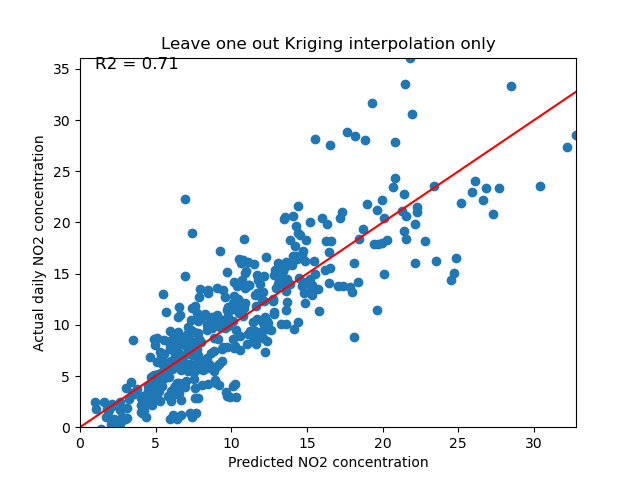

In [400]:
%matplotlib widget

ps = np.array(predicts)
As = np.array(actuals)

plt.title('Leave one out Kriging interpolation only')
plt.scatter(ps, As)
plt.plot(np.arange(0, 60, 0.1), np.arange(0, 60, 0.1), c='red')
plt.xlim(0, np.amax(ps))
plt.ylim(0, np.amax(As))
plt.xlabel('Predicted NO2 concentration')
plt.ylabel('Actual daily NO2 concentration')
plt.text(1, 35, 'R2 = %s' % round(r2_score(As, ps), 2), fontsize='large')